In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.metrics import make_scorer
plt.rcParams["figure.figsize"] = (10,10)

In [10]:
# labelling 
# Normal : 0
# Spondylolisthesis : 1
# Hernia : 2

In [11]:
def convert_labels(y):
    j = y.copy()
    j[j=='Normal'] = 0
    j[j=='Spondylolisthesis'] = 1
    j[j=='Hernia'] = 2
    j = j.astype('int32')
    return j
    

### Loading the Dataset

In [12]:
x_train = pd.read_csv('x_train.csv')
x_test = pd.read_csv('x_test.csv')
y_train = convert_labels(pd.read_csv('y_train.csv')['class'])
y_test = convert_labels(pd.read_csv('y_test.csv')['class'])

### Defining the metrics 

In [13]:
def Normalprecision(y_true, y_pred):
    mask_true = (y_true == 0)
    mask_pred = (y_pred == 0)
    true_pos = (mask_true & mask_pred).sum()
    return true_pos/(mask_pred.sum())

def NormalRecall(y_true, y_pred):
    mask_true = (y_true == 0)
    mask_pred = (y_pred == 0)
    true_pos = (mask_true & mask_pred).sum()
    return true_pos/(mask_true.sum())


def Spondprecision(y_true, y_pred):
    mask_true = (y_true == 1)
    mask_pred = (y_pred == 1)
    true_pos = (mask_true & mask_pred).sum()
    return true_pos/(mask_pred.sum())

def SpondRecall(y_true, y_pred):
    mask_true = (y_true == 1)
    mask_pred = (y_pred == 1)
    true_pos = (mask_true & mask_pred).sum()
    return true_pos/(mask_true.sum())

def Herniaprecision(y_true, y_pred):
    mask_true = (y_true == 2)
    mask_pred = (y_pred == 2)
    true_pos = (mask_true & mask_pred).sum()
    return true_pos/(mask_pred.sum())

def HerniaRecall(y_true, y_pred):
    mask_true = (y_true == 2)
    mask_pred = (y_pred == 2)
    true_pos = (mask_true & mask_pred).sum()
    return true_pos/(mask_true.sum())


def computemetrics(y_true, y_pred):
    return {'Normalprecision':Normalprecision(y_true, y_pred),
            'NormalRecall':NormalRecall(y_true, y_pred),
            'Spondprecision':Spondprecision(y_true, y_pred),
            'SpondRecall':SpondRecall(y_true, y_pred),
            'HerniaPrecision':Herniaprecision(y_true, y_pred),
             'HerniaRecall':HerniaRecall(y_true, y_pred)}

### Defining a GridEval class that 

In [14]:
class GridEval:
    def __init__(self, pipe, param, cross, x_train, y_train, x_test, y_test):
        self.pipe = pipe
        self.param = param
        self.cross = cross
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
    
    def fit(self):
        scores = ['NormalPrecision','NormalRecall', 'SpondPrecision', 'SpondRecall', 'HerniaPrecision',
                                                 'HerniaRecall']
        grids = [GridSearchCV(estimator = self.pipe, param_grid = self.param,
                             scoring = {'NormalPrecision': make_scorer(Normalprecision),
                                  'NormalRecall': make_scorer(NormalRecall),
                                  'SpondPrecision': make_scorer(Spondprecision),
                                  'SpondRecall': make_scorer(SpondRecall),
                                  'HerniaPrecision':make_scorer(Herniaprecision),
                                  'HerniaRecall': make_scorer(HerniaRecall)},
                             cv = self.cross,
                             n_jobs = -1,
                             refit = i) for i in scores]
        for g in grids:
            print(g.get_params()['refit'])
            g.fit(self.x_train, self.y_train)

        best_models = [g.best_estimator_ for g in grids]
        cv_results = {g.get_params()['refit']:pd.DataFrame(g.cv_results_) for g in grids}
        result = {}
        for i in range(len(best_models)):
            result[grids[i].get_params()['refit']] = computemetrics(self.y_test, best_models[i].predict(self.x_test))

        return best_models, result, cv_results

    
    
    

In [15]:
pipe = Pipeline([('transformer', QuantileTransformer(n_quantiles = 100)),
                 ('model', LogisticRegression())])

param = {'model__class_weight':[{0:v-1, 1:1, 2:v} for v in range(2, 10)]}

In [16]:
grid = GridEval(pipe, param, 5, x_train, y_train, x_test, y_test)

In [17]:
models, result, cv_results = grid.fit()

NormalPrecision
NormalRecall
SpondPrecision
SpondRecall
HerniaPrecision
HerniaRecall


In [18]:
def plot(cv_result, title, xlabel, ylabel):
    scores = ['NormalPrecision','NormalRecall', 'SpondPrecision', 'SpondRecall', 'HerniaPrecision','HerniaRecall']
    for i in scores:
        plt.plot(np.arange(cv_result.shape[0]), cv_result[f'mean_test_{i}'], label = i)
    plt.legend()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    
    

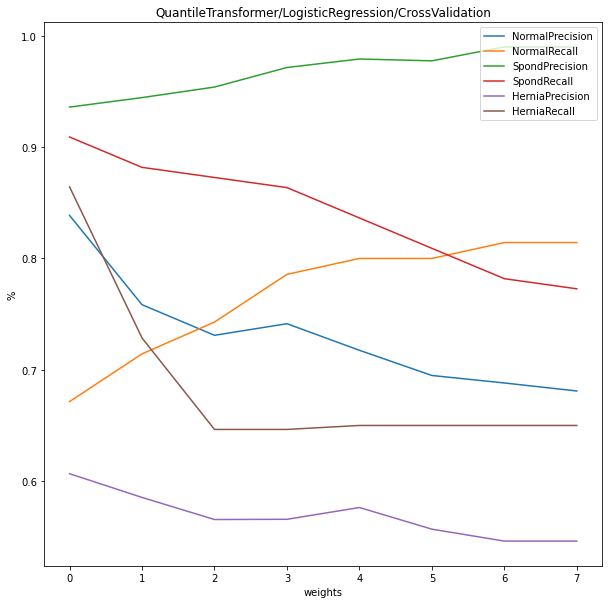

In [24]:
plot(cv_results['NormalPrecision'], 'QuantileTransformer/LogisticRegression/CrossValidation', 'weights', '%')

In [20]:
pipe2 = Pipeline([('transformer', StandardScaler()),
                 ('model', LogisticRegression())])

In [21]:
grid2 = GridEval(pipe2, param, 5, x_train, y_train, x_test, y_test)

In [22]:
models2, result2, cv_results2 = grid2.fit()

NormalPrecision
NormalRecall
SpondPrecision
SpondRecall
HerniaPrecision
HerniaRecall


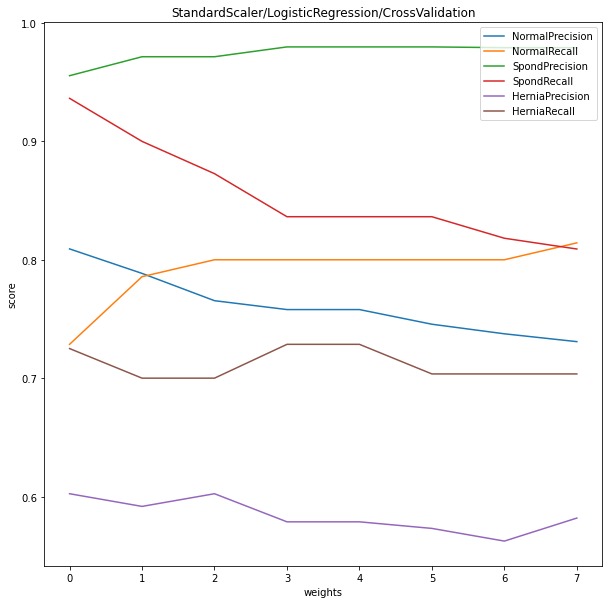

In [25]:
plot(cv_results2['NormalPrecision'], 'StandardScaler/LogisticRegression/CrossValidation', 'weights', 'score')